In [1]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import optuna
import matplotlib.pyplot as plt
import pandas as pd

d:\LUIS PP\ULPGC\TERCERO\AA2\PrimeraPractica\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Redimensionamos las imágenes a 128x128
    transforms.ToTensor(),            # Convertimos las imágenes a tensores
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalizamos con media 0.5 y desviación estándar 0.5
])

# Cargamos el dataset de Rock, Paper, Scissors
dataset_path = 'Flags'  # Cambia esto a la ruta donde descargaste el dataset
train_data = datasets.ImageFolder(root=dataset_path, transform=transform)

# Calcular el tamaño del conjunto de datos
dataset_size = len(train_data)

# Definir proporciones para dividir el dataset en entrenamiento y prueba (80% entrenamiento, 20% prueba)
train_size = int(0.8 * dataset_size)
test_size = dataset_size - train_size

# Dividir el dataset en entrenamiento y prueba
train_dataset, test_dataset = random_split(train_data, [train_size, test_size])

# Crear DataLoader para los conjuntos de entrenamiento y prueba
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Imprimir el número de clases y sus nombres
class_names = train_data.classes
print(f'Clases encontradas: {class_names}')
print(f"Numero de clases: {len(class_names)}")
print(f'Tamaño del conjunto de entrenamiento: {len(train_loader.dataset)}')
print(f'Tamaño del conjunto de prueba: {len(test_loader.dataset)}')

Clases encontradas: ['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Czech Republic', 'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Holland', 'Hungary', 'Ireland', 'Italy', 'Latvia', 'Lithuania', 'Luxembourg', 'Malta', 'Slovakia', 'Slovenia', 'South Cyprus', 'Spain', 'Sweden']
Numero de clases: 24
Tamaño del conjunto de entrenamiento: 796
Tamaño del conjunto de prueba: 200


In [3]:
class ConvNet(nn.Module):
    def __init__(self, num_filters_conv1=16, num_filters_conv2=32, kernel_size_conv1=5, kernel_size_conv2=5,
                 fc1_units=120, fc2_units=24, dropout_rate=0.0, activation=nn.ReLU):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, num_filters_conv1, kernel_size=kernel_size_conv1, stride=1, padding=kernel_size_conv1 // 2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(num_filters_conv1, num_filters_conv2, kernel_size=kernel_size_conv2, stride=1, padding=kernel_size_conv2 // 2)
        
        self.fc1 = nn.Linear(num_filters_conv2 * 32 * 32, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.dropout = nn.Dropout(dropout_rate)
        self.activation = activation()  # Instancia de la función de activación

    def forward(self, x):
        x = self.pool(self.activation(self.conv1(x)))
        x = self.pool(self.activation(self.conv2(x)))
        x = x.view(-1, x.size(1) * x.size(2) * x.size(3))  # Aplanar
        x = self.dropout(self.activation(self.fc1(x)))
        x = self.fc2(x)
        return x

In [4]:
model = ConvNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Entrenamiento
epochs = 5
for epoch in range(epochs):
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()  # Limpiamos los gradientes
        outputs = model(images)  # Pasamos las imágenes por la red
        loss = criterion(outputs, labels)  # Calculamos la pérdida
        loss.backward()  # Backpropagation
        optimizer.step()  # Actualizamos los pesos
        
        running_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}')

Epoch 1, Loss: 2.668324268781222
Epoch 2, Loss: 1.0491271339930022
Epoch 3, Loss: 0.6430954589293554
Epoch 4, Loss: 0.34678268891114455
Epoch 5, Loss: 0.2088012884442623


In [5]:
correct = 0
total = 0
with torch.no_grad():  # No necesitamos calcular gradientes para la evaluación
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the model: {100 * correct / total}%')

Accuracy of the model: 76.0%


In [6]:
# Función para definir el modelo
def create_model(trial):
    # Sugerir valores de hiperparámetros para el modelo
    num_filters_conv1 = trial.suggest_int('num_filters_conv1', 8, 64, step=8)
    num_filters_conv2 = trial.suggest_int('num_filters_conv2', 16, 128, step=16)
    kernel_size_conv1 = trial.suggest_int('kernel_size_conv1', 3, 7, step=2)
    kernel_size_conv2 = trial.suggest_int('kernel_size_conv2', 3, 7, step=2)
    fc1_units = trial.suggest_int('fc1_units', 64, 512, step=64)
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5)
    activation = trial.suggest_categorical('activation', [nn.ReLU, nn.LeakyReLU, nn.ELU])
    
    # Crear el modelo con los hiperparámetros sugeridos
    model = ConvNet(
        num_filters_conv1=num_filters_conv1,
        num_filters_conv2=num_filters_conv2,
        kernel_size_conv1=kernel_size_conv1,
        kernel_size_conv2=kernel_size_conv2,
        fc1_units=fc1_units,
        dropout_rate=dropout_rate,
        activation=activation
    )
    
    # Sugerir el learning rate y el optimizador
    learning_rate = trial.suggest_loguniform('lr', 0.00001, 0.001)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'SGD', 'RMSprop'])
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=learning_rate)
    
    return model, optimizer

# Función de entrenamiento
def train_model(trial):
    model, optimizer = create_model(trial)
    criterion = nn.CrossEntropyLoss()
    
    # Hiperparámetros
    batch_size = trial.suggest_int('batch_size', 16, 128, step=16)  # Tamaño de lote
    epochs = 5
    
    # Crear DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
    
    # Evaluar el modelo
    accuracy = evaluate_model(model, test_loader)
    
    return accuracy  # Devuelve la métrica que se quiere optimizar

# Función para evaluar el modelo
def evaluate_model(model, test_loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    return correct / total  # Devuelve la precisión

# Crear un estudio y optimizar
study = optuna.create_study(direction='maximize')
study.optimize(train_model, n_trials=7)

[I 2024-11-17 17:56:33,658] A new study created in memory with name: no-name-d3a43206-05a1-442b-8e81-f8c1498549b1
d:\LUIS PP\ULPGC\TERCERO\AA2\PrimeraPractica\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.nn.modules.activation.ReLU'> which is of type type.
  warnings.warn(message)
d:\LUIS PP\ULPGC\TERCERO\AA2\PrimeraPractica\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.nn.modules.activation.LeakyReLU'> which is of type type.
  warnings.warn(message)
d:\LUIS PP\ULPGC\TERCERO\AA2\PrimeraPractica\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <cl

In [7]:
lr_list = []
batch_size_list = []
num_filters_conv1_list = []
num_filters_conv2_list = []
kernel_size_conv1_list = []
kernel_size_conv2_list = []
fc1_units_list = []
dropout_rate_list = []
activation_list = []
optimizer_list = []
accuracy_list = []

for trial in study.trials:
    # Obtener el valor de la precisión (o cualquier otra métrica de validación)
    accuracy = trial.value
    
    # Obtener los hiperparámetros sugeridos para cada prueba
    num_filters_conv1 = trial.params['num_filters_conv1']
    num_filters_conv2 = trial.params['num_filters_conv2']
    kernel_size_conv1 = trial.params['kernel_size_conv1']
    kernel_size_conv2 = trial.params['kernel_size_conv2']
    fc1_units = trial.params['fc1_units']
    dropout_rate = trial.params['dropout_rate']
    activation = trial.params['activation']
    lr = trial.params['lr']
    optimizer = trial.params['optimizer']
    batch_size = trial.params['batch_size']
    
    # Almacenar los resultados en las listas
    lr_list.append(lr)
    batch_size_list.append(batch_size)
    num_filters_conv1_list.append(num_filters_conv1)
    num_filters_conv2_list.append(num_filters_conv2)
    kernel_size_conv1_list.append(kernel_size_conv1)
    kernel_size_conv2_list.append(kernel_size_conv2)
    fc1_units_list.append(fc1_units)
    dropout_rate_list.append(dropout_rate)
    activation_list.append(activation)
    optimizer_list.append(optimizer)
    accuracy_list.append(accuracy)

# Crear un DataFrame para visualizar los resultados
results_df = pd.DataFrame({
    'Accuracy': accuracy_list,
    'LR': lr_list,
    'Batch Size': batch_size_list,
    'Num Filters Conv1': num_filters_conv1_list,
    'Num Filters Conv2': num_filters_conv2_list,
    'Kernel Size Conv1': kernel_size_conv1_list,
    'Kernel Size Conv2': kernel_size_conv2_list,
    'FC1 Units': fc1_units_list,
    'Dropout Rate': dropout_rate_list,
    'Activation': activation_list,
    'Optimizer': optimizer_list
})

# Mostrar el DataFrame
# Definir el dispositivo (GPU si está disponible, sino CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(results_df)

   Accuracy        LR  Batch Size  Num Filters Conv1  Num Filters Conv2  \
0     0.560  0.000038          96                  8                 80   
1     0.055  0.000401          80                 16                 48   
2     0.465  0.000023         128                 40                112   
3     0.800  0.000420          48                 32                 48   
4     0.365  0.000050         128                 24                 16   
5     0.675  0.000156          48                  8                 64   
6     0.760  0.000232          16                 56                112   

   Kernel Size Conv1  Kernel Size Conv2  FC1 Units  Dropout Rate  \
0                  3                  5        128      0.231411   
1                  3                  7        256      0.151217   
2                  7                  3        448      0.338017   
3                  5                  5        512      0.023223   
4                  5                  5        320      0.0

Completado el entrenamiento para combinación: (8, 80, 3, 5, 128, 0.23141103404036217, 'ELU', 3.783216173225695e-05, 96)


C:\Users\INES\AppData\Local\Temp\ipykernel_11068\3277620944.py:104: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper left')


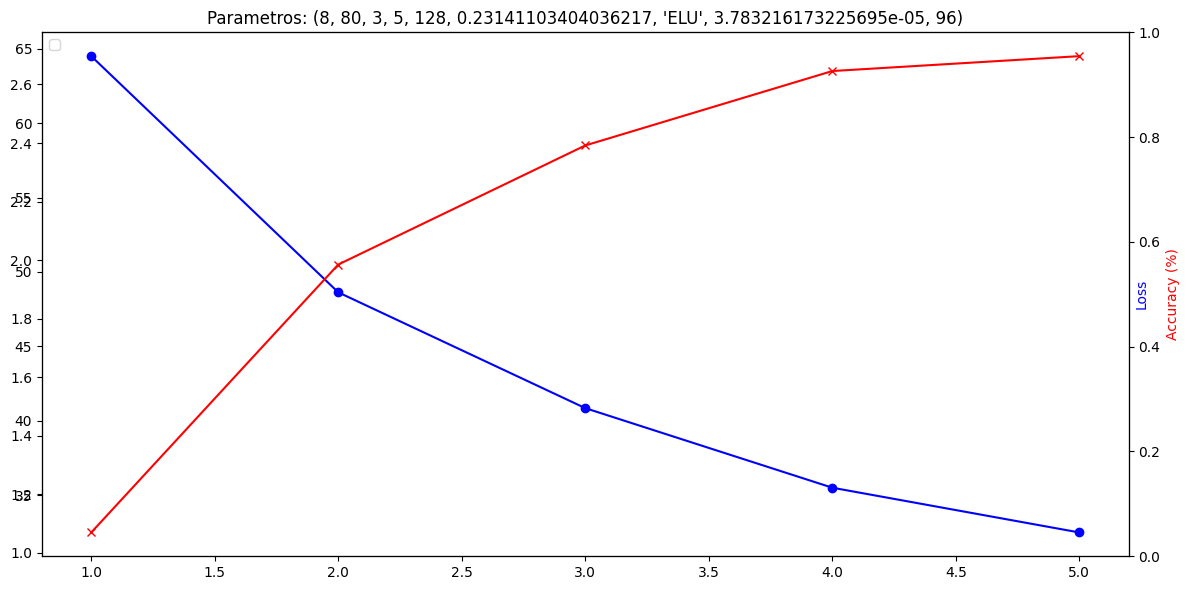

Completado el entrenamiento para combinación: (16, 48, 3, 7, 256, 0.1512174307965683, 'ReLU', 0.0004011490409428876, 80)


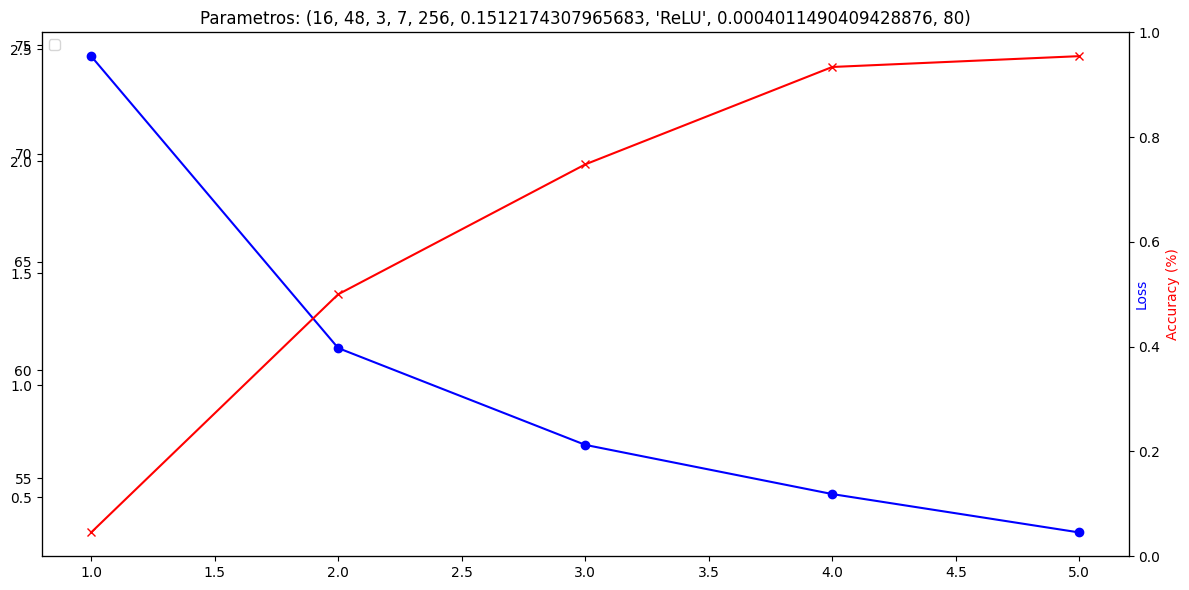

Completado el entrenamiento para combinación: (40, 112, 7, 3, 448, 0.3380165871733056, 'LeakyReLU', 2.343534497585189e-05, 128)


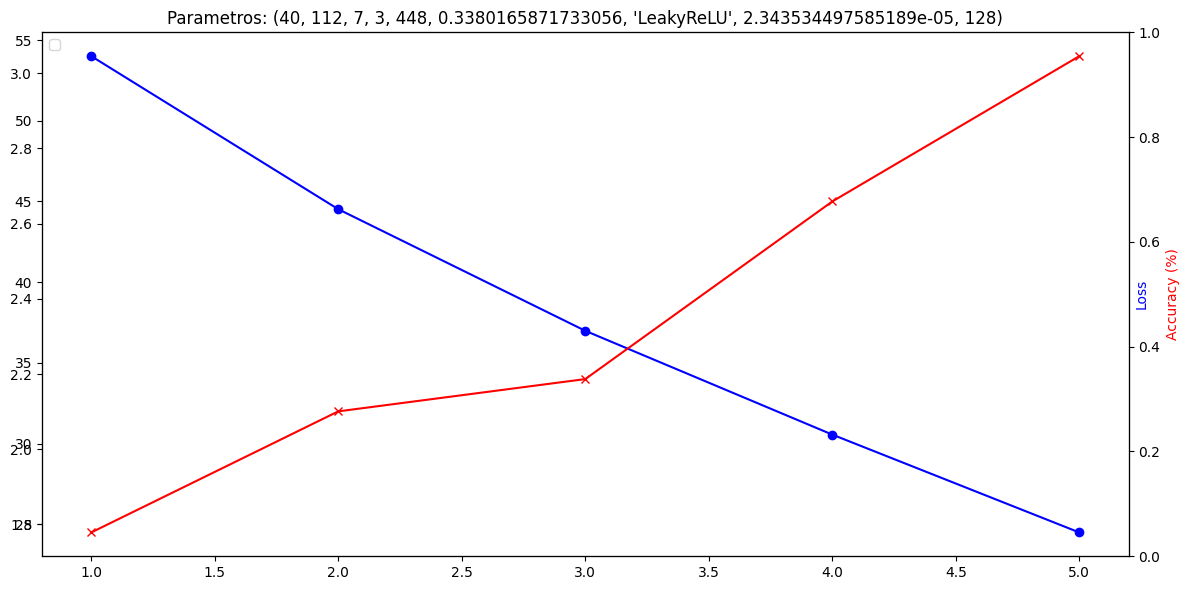

Completado el entrenamiento para combinación: (32, 48, 5, 5, 512, 0.023222698415030163, 'LeakyReLU', 0.00041957000230563547, 48)


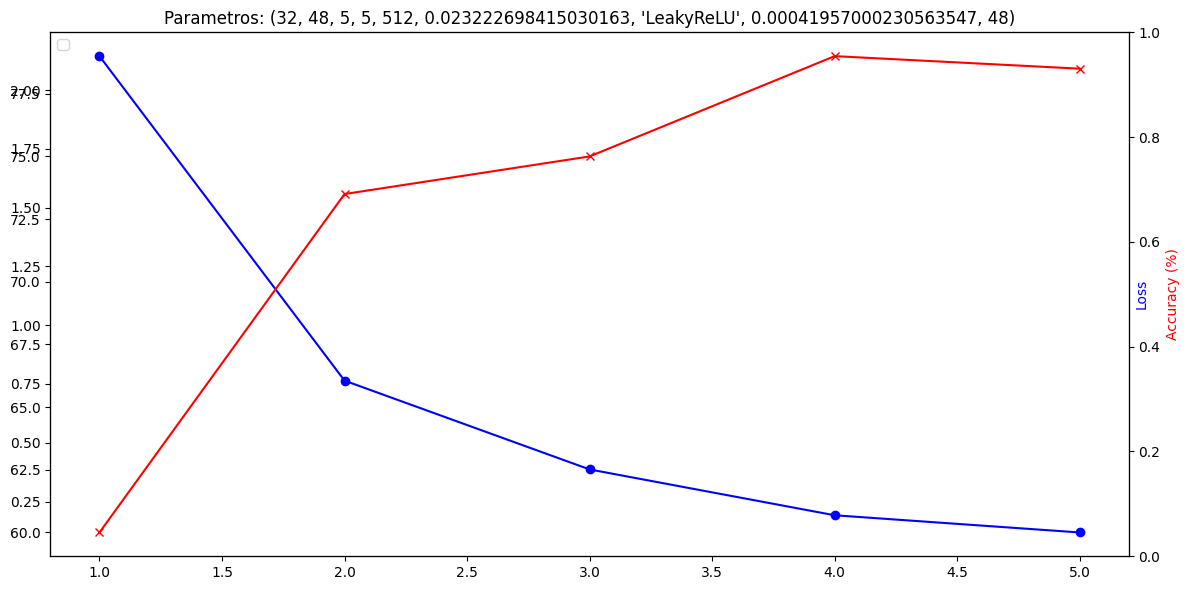

Completado el entrenamiento para combinación: (24, 16, 5, 5, 320, 0.06696454979516037, 'LeakyReLU', 4.969694384948225e-05, 128)


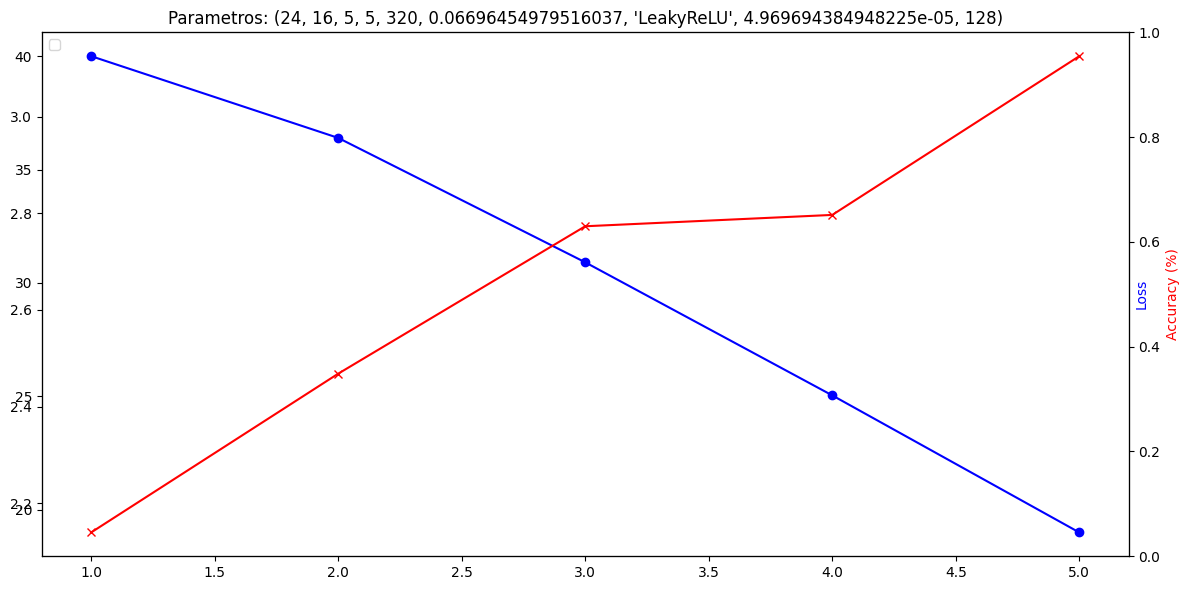

Completado el entrenamiento para combinación: (8, 64, 3, 3, 384, 0.18028847348698573, 'LeakyReLU', 0.0001556334052487901, 48)


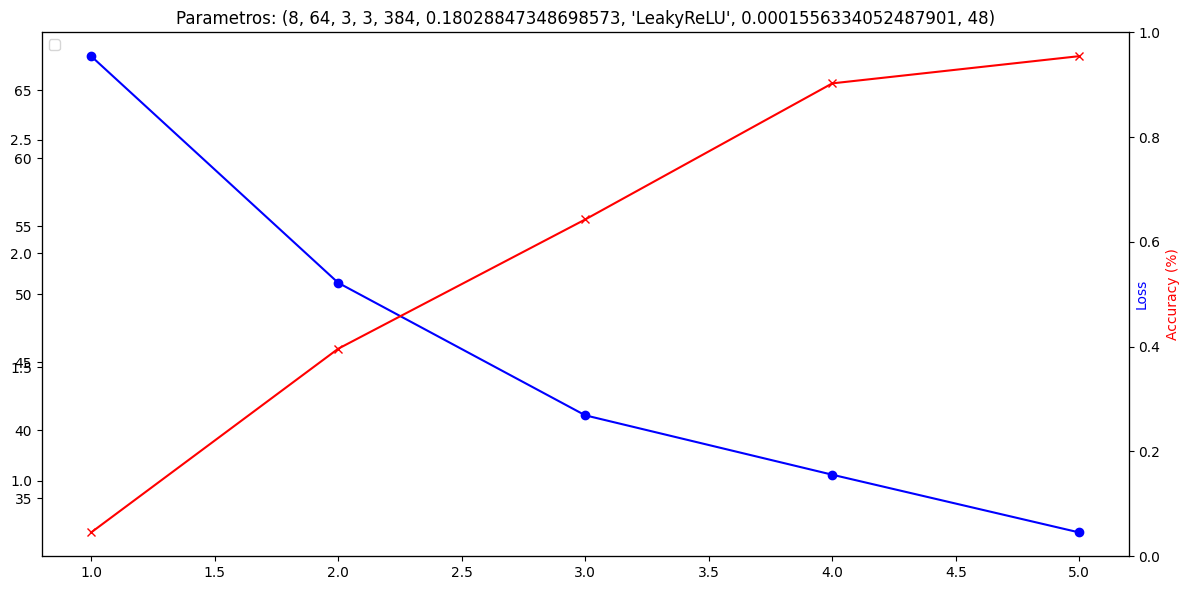

Completado el entrenamiento para combinación: (56, 112, 3, 7, 448, 0.4756208213742231, 'LeakyReLU', 0.00023178422938267083, 16)


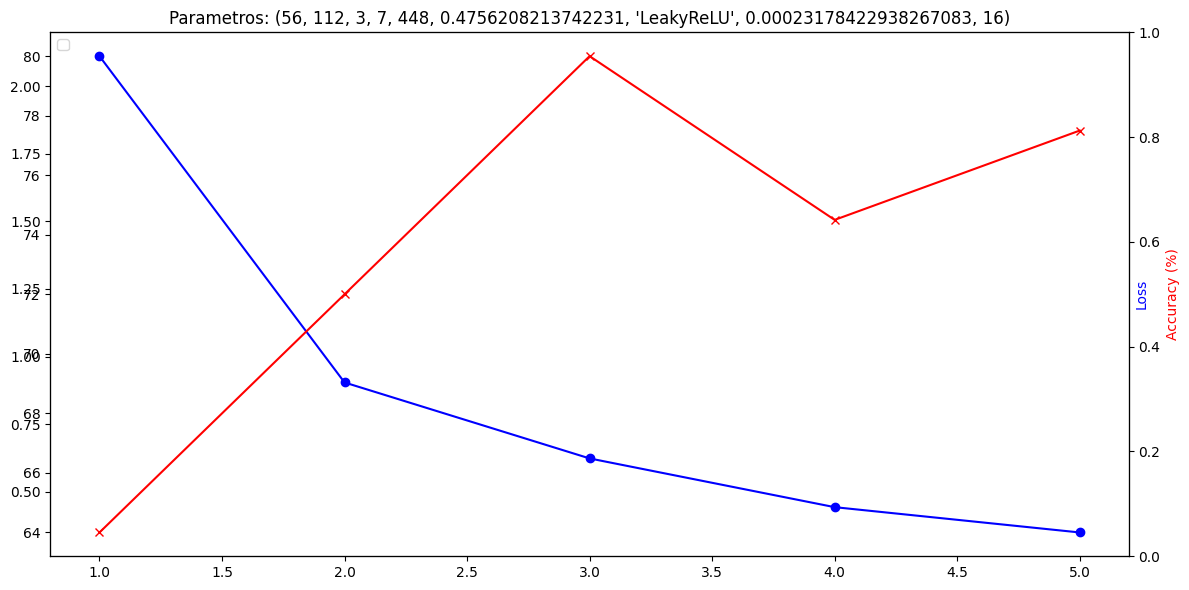

In [8]:
# Definir ConvNet con parámetros dinámicos
class ConvNet(nn.Module):
    def __init__(self, num_filters_conv1, num_filters_conv2, kernel_size_conv1, kernel_size_conv2, fc1_units, dropout_rate, activation):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, num_filters_conv1, kernel_size=kernel_size_conv1, stride=1, padding=kernel_size_conv1 // 2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(num_filters_conv1, num_filters_conv2, kernel_size=kernel_size_conv2, stride=1, padding=kernel_size_conv2 // 2)
        
        # Calcular el tamaño de las imágenes después del pooling (asumiendo entrada 128x128)
        self.feature_map_size = 128 // 4  # 2 capas de pooling
        self.fc1 = nn.Linear(num_filters_conv2 * self.feature_map_size * self.feature_map_size, fc1_units)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.fc2 = nn.Linear(fc1_units, 24)
        self.activation = activation()

    def forward(self, x):
        x = self.activation(self.conv1(x))
        x = self.pool(x)
        x = self.activation(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, x.size(1) * x.size(2) * x.size(3))  # Flatten
        x = self.activation(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Entrenamiento y evaluación
accuracies = {}
train_losses = {}

for trial in study.trials:
    # Extraer los mejores hiperparámetros
    params = trial.params
    num_filters_conv1 = params['num_filters_conv1']
    num_filters_conv2 = params['num_filters_conv2']
    kernel_size_conv1 = params['kernel_size_conv1']
    kernel_size_conv2 = params['kernel_size_conv2']
    fc1_units = params['fc1_units']
    dropout_rate = params['dropout_rate']
    activation = params['activation']
    lr = params['lr']
    batch_size = params['batch_size']
    
    # Definir el modelo
    model = ConvNet(num_filters_conv1, num_filters_conv2, kernel_size_conv1, kernel_size_conv2, fc1_units, dropout_rate, activation).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    # Cargar los datos con el batch_size correspondiente
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Inicializar métricas
    epoch_train_losses = []
    epoch_accuracies = []

    epochs = 5
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        average_loss = running_loss / len(train_loader)
        epoch_train_losses.append(average_loss)

        # Evaluar precisión
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = correct / total * 100
        epoch_accuracies.append(accuracy)
    
    # Guardar métricas
    key = (num_filters_conv1, num_filters_conv2, kernel_size_conv1, kernel_size_conv2, fc1_units, dropout_rate, activation.__name__, lr, batch_size)
    accuracies[key] = epoch_accuracies
    train_losses[key] = epoch_train_losses

    print(f"Completado el entrenamiento para combinación: {key}")

    # Graficar
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, epochs + 1), epoch_train_losses, label='Loss', color='blue', marker='o')
    plt.twinx()
    plt.plot(range(1, epochs + 1), epoch_accuracies, label='Accuracy', color='red', marker='x')
    plt.title(f"Parametros: {key}")
    plt.xlabel('Epoch')
    plt.ylabel('Loss', color='blue')
    plt.gca().twinx().set_ylabel('Accuracy (%)', color='red')
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()


# Prueba grafica hiperparametros

Epoch 1, Loss: 0.11956227966584265, Accuracy: 80.0%
Epoch 2, Loss: 0.08519488691119477, Accuracy: 78.5%
Epoch 3, Loss: 0.07656034280429594, Accuracy: 79.0%
Epoch 4, Loss: 0.04402378969709389, Accuracy: 80.0%
Epoch 5, Loss: 0.061578041646862404, Accuracy: 78.5%
Epoch 6, Loss: 0.03485451486078091, Accuracy: 80.5%
Epoch 7, Loss: 0.06181996876141056, Accuracy: 79.0%
Epoch 8, Loss: 0.029918149256845935, Accuracy: 80.5%
Epoch 9, Loss: 0.017008576361113227, Accuracy: 80.0%
Epoch 10, Loss: 0.015628962186747232, Accuracy: 81.0%


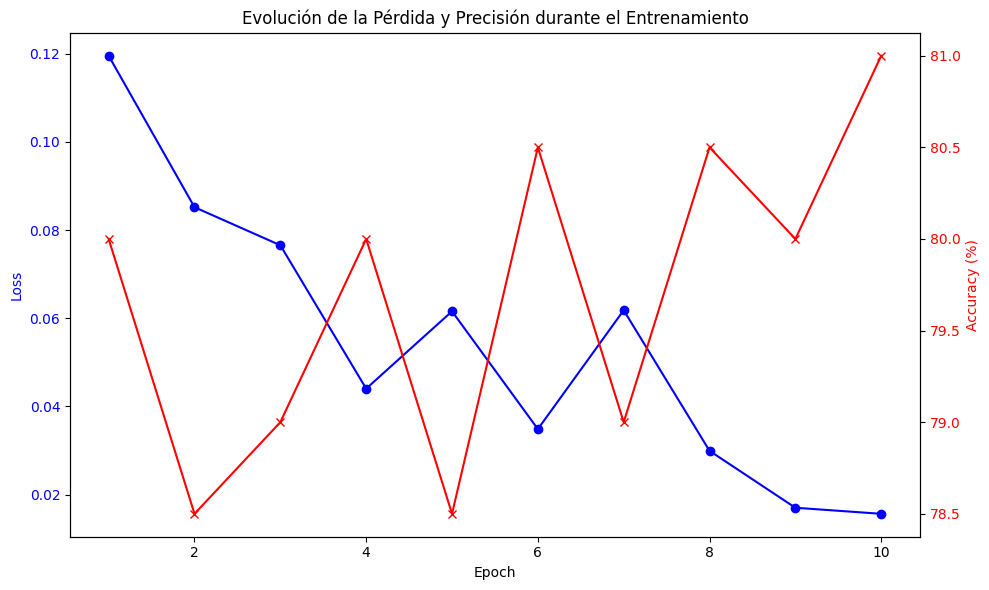

In [9]:
# Inicializar listas para guardar la pérdida y precisión por cada época
train_losses = []
test_accuracies = []

# Entrenamiento con almacenamiento de pérdida y precisión en cada época
epochs = 10
for epoch in range(epochs):
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()  
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    # Calcular pérdida promedio y guardarla
    average_loss = running_loss / len(train_loader)
    train_losses.append(average_loss)
    
    # Evaluar precisión en el conjunto de prueba después de cada época
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = correct / total * 100  # Convertir a porcentaje
    test_accuracies.append(accuracy)
    
    print(f"Epoch {epoch+1}, Loss: {average_loss}, Accuracy: {accuracy}%")

# Graficar pérdida y precisión por época
fig, ax1 = plt.subplots(figsize=(10, 6))

# Graficar pérdida en el eje izquierdo
ax1.plot(range(1, epochs+1), train_losses, 'b-', marker='o', label='Training Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Crear un segundo eje para la precisión
ax2 = ax1.twinx()
ax2.plot(range(1, epochs+1), test_accuracies, 'r-', marker='x', label='Test Accuracy')
ax2.set_ylabel('Accuracy (%)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Títulos y leyendas
plt.title('Evolución de la Pérdida y Precisión durante el Entrenamiento')
fig.tight_layout()
plt.show()


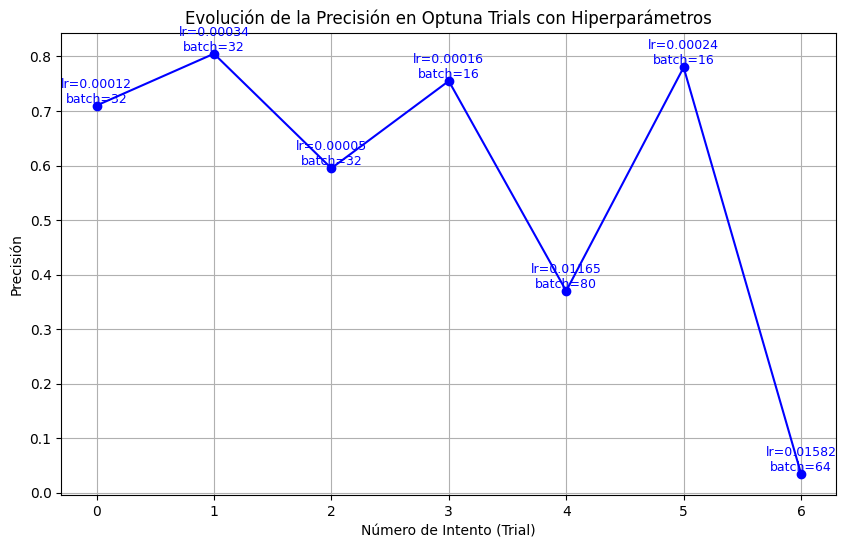

In [10]:
# Datos de precisión y parámetros para cada trial
trial_indices = [0, 1, 2, 3, 4, 5, 6]
accuracies = [0.71, 0.805, 0.595, 0.755, 0.37, 0.78, 0.035]
learning_rates = [0.00011845635128922477, 0.00034205224703310954, 5.497929010429049e-05,
                  0.00016088397996164212, 0.011649552713214087, 0.0002356410504187102,
                  0.015819693843285913]
batch_sizes = [32, 32, 32, 16, 80, 16, 64]

# Crear el gráfico de precisión
plt.figure(figsize=(10, 6))
plt.plot(trial_indices, accuracies, 'bo-', label='Precisión')

# Añadir etiquetas de lr y batch_size en cada punto
for i, (x, y, lr, bs) in enumerate(zip(trial_indices, accuracies, learning_rates, batch_sizes)):
    plt.text(x, y, f'lr={lr:.5f}\nbatch={bs}', ha='center', va='bottom', fontsize=9, color='blue')

# Configuraciones de la gráfica
plt.xlabel("Número de Intento (Trial)")
plt.ylabel("Precisión")
plt.title("Evolución de la Precisión en Optuna Trials con Hiperparámetros")
plt.grid(True)
plt.show()
